# Cosinor Regression Model used for 24-hours Window Analysis

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma import add
from CosinorPy import file_parser, cosinor, cosinor1, cosinor_nonlin
np.seterr(divide='ignore')
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import percentileofscore
from scipy.stats import circstd, circmean

import copy
import itertools
from random import sample
import os
import copy
from CosinorPy.helpers import df_add_row

### Data Preparation

In [6]:
def load_data(path):
    """Function used to parser the data using the file_parser method from the CosinorPy package"""
    df = pd.read_csv(path)
    df['Region start time'] = pd.to_datetime(df['Region start time'])
    df['date'] = df['Region start time'].dt.date
    df['hour'] = df['Region start time'].dt.hour
    df = df.drop('Unnamed: 0', axis=1)
    return df

In [7]:
pre_data = load_data("data/RNS_G_Pre_output.csv")
post_data = load_data("data/RNS_G_M1_output.csv")

In [66]:
def prepare_data(df):
    """Function used to prepare the data for Cosinor Regression"""
    df1 = df.copy()
    df1["test"] = df1["date"].astype(str)
    df1["x"] = df1["hour"]
    df1["y"] = df1["Pattern A Channel 2"]

    return df1

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


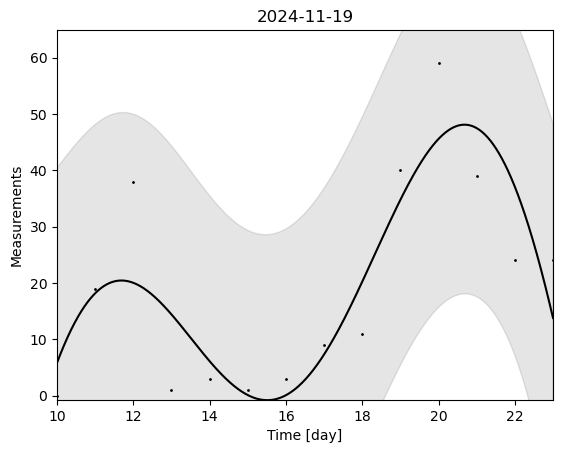

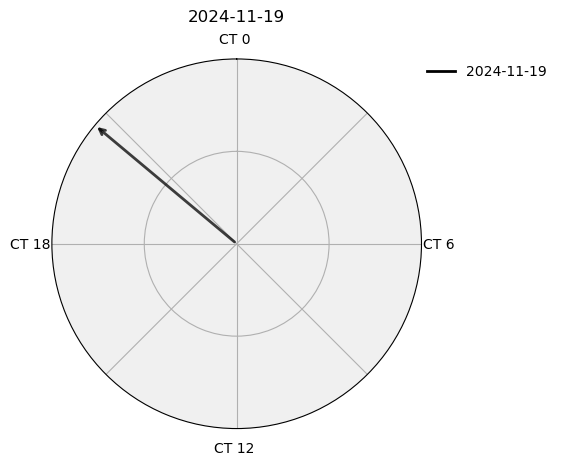

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


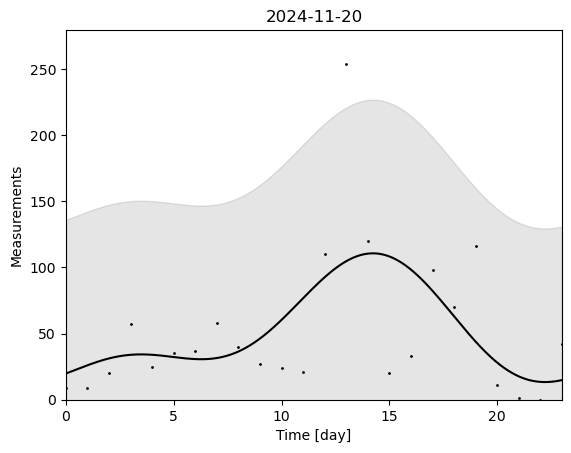

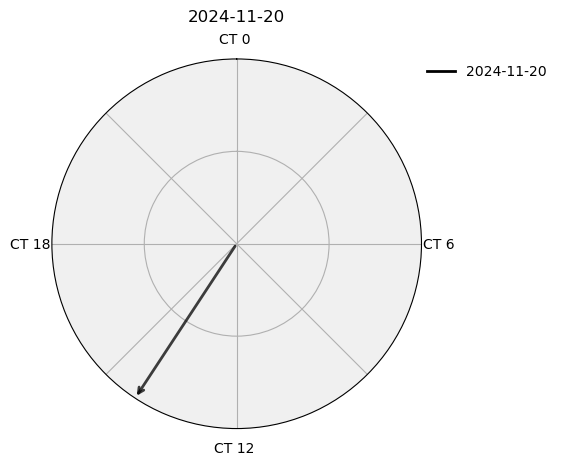

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


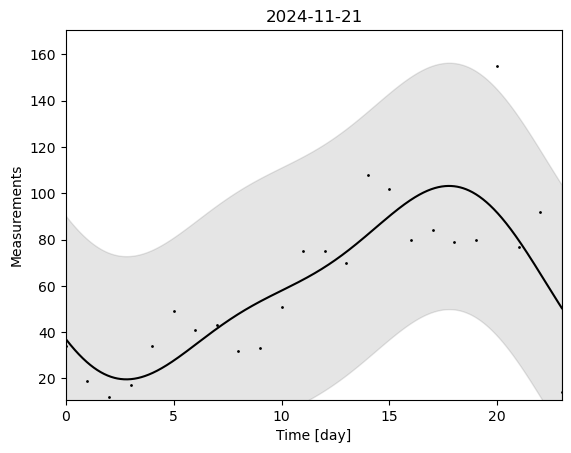

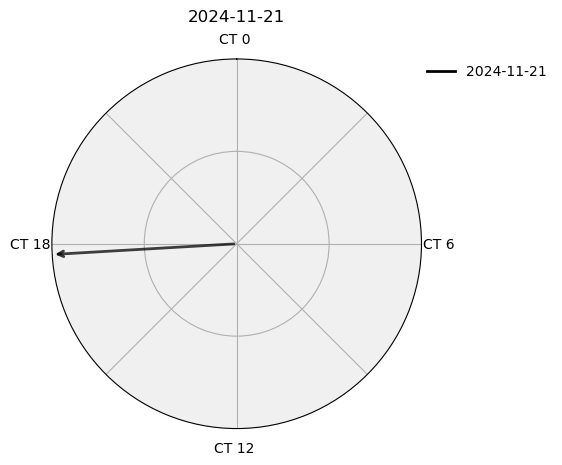

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


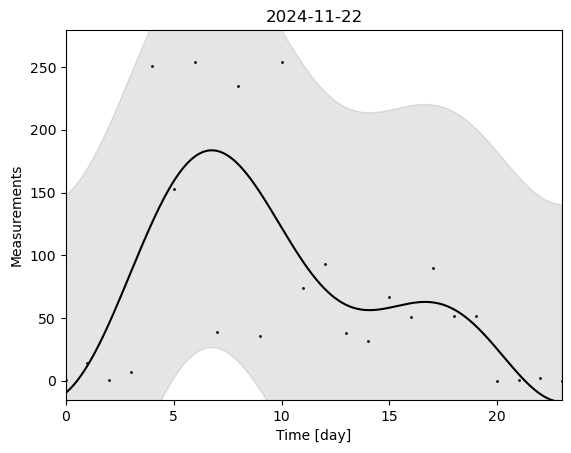

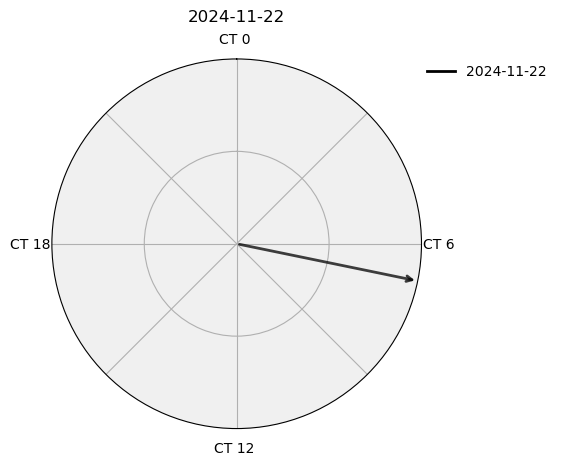

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


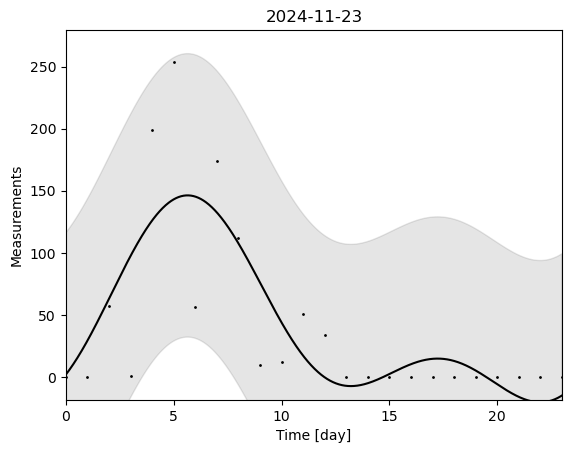

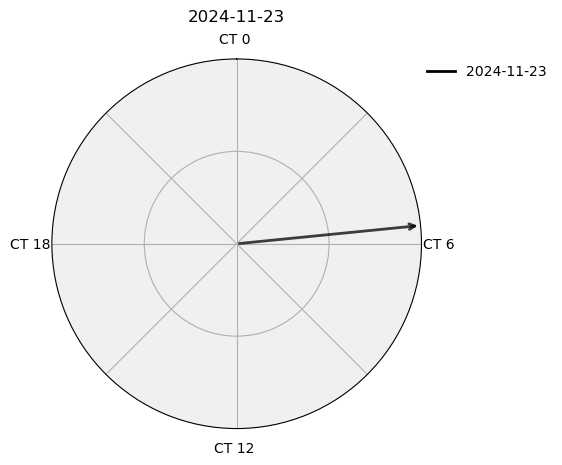

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


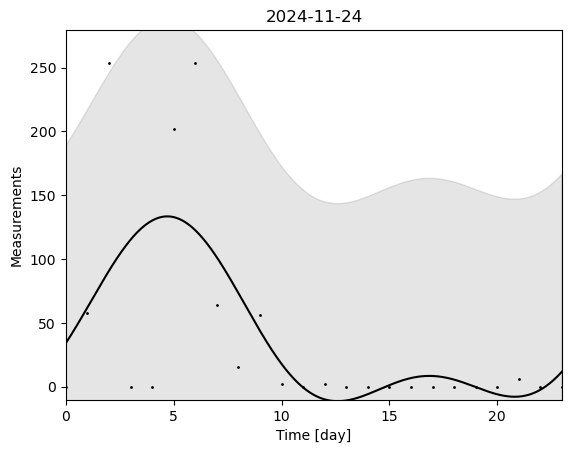

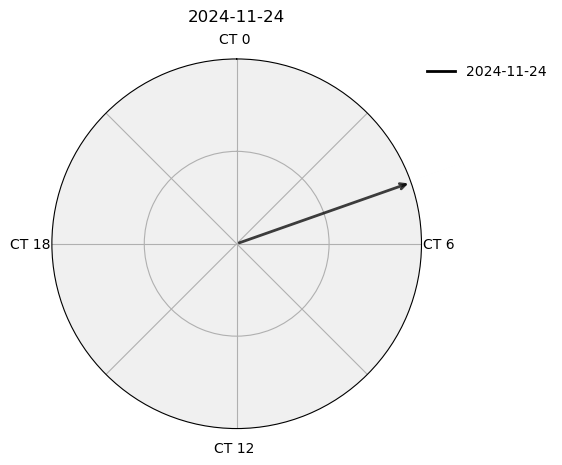

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


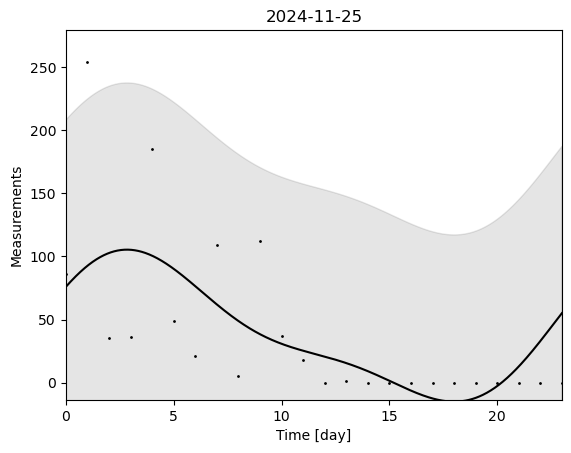

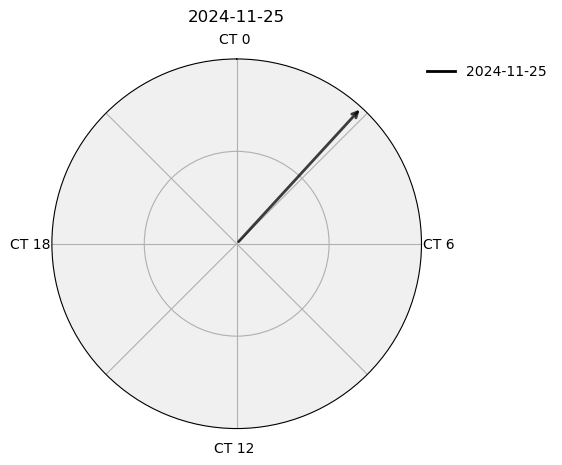

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


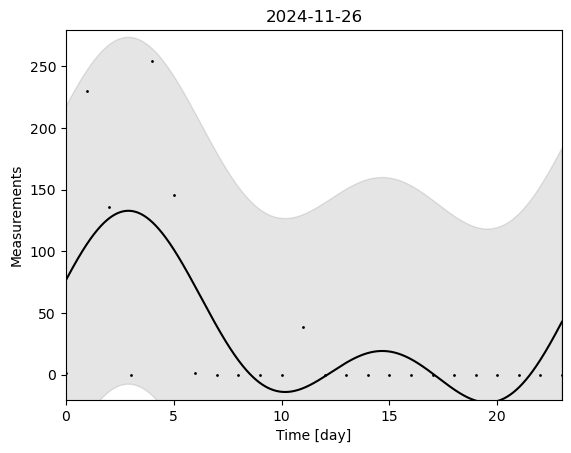

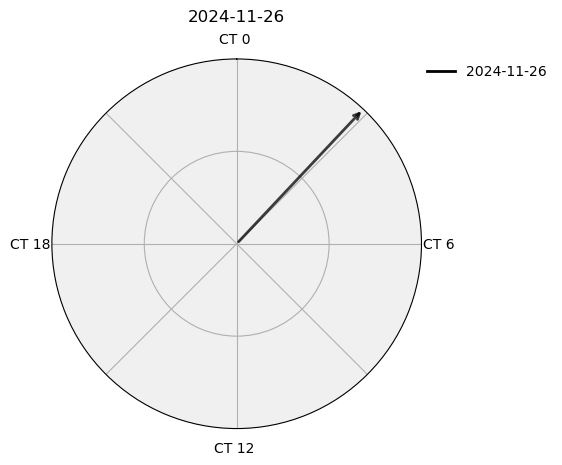

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


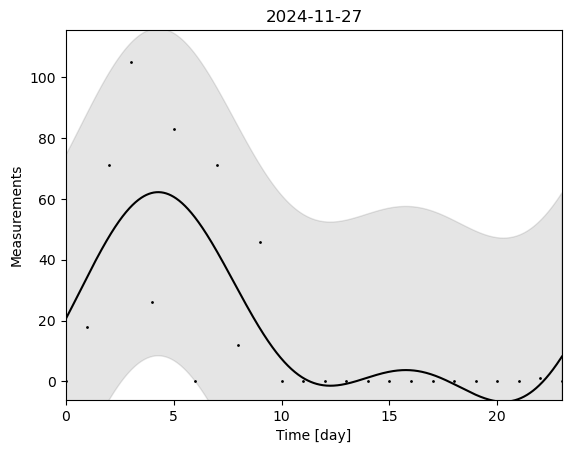

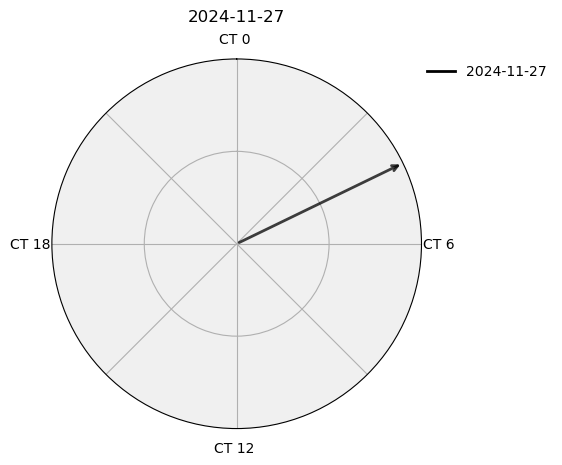

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


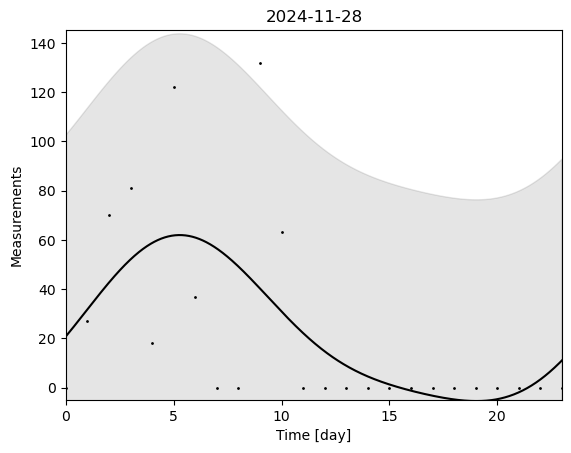

In [ ]:
cosinor.fit_group(prepare_data(pre_data))
cosinor.fit_me(post_data["hour"], post_data["Pattern A Channel 2"])